In [1]:
from typing import List, Dict
from functools import reduce
from itertools import product

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_network(vertices: Dict[str, pd.DataFrame], edge_list: List[List[str]]) -> nx.DiGraph:
    g = nx.DiGraph()
    for vertex, probas in vertices.items():
        g.add_node(vertex, prob=probas)
    for edge in edge_list:
        g.add_edge(*edge)
    return g

In [3]:
def merge_prob_tables(df1: pd.DataFrame, df2:pd.DataFrame, left: str, right: str) -> pd.DataFrame:
    df_first = df1.reset_index()
    first_indexes = [col for col in df_first.columns if col.startswith('index')]
    df_second = df2.reset_index()
    second_indexes = [col for col in df_second.columns if col.startswith('index')]
    
    df_first = df_first.melt(id_vars=first_indexes, 
                      var_name=f'variable_{left}',
                      value_name=f'value_{left}')
    
    df_second = df_second.melt(id_vars=second_indexes, 
                      var_name=f'variable_{right}',
                      value_name=f'value_{right}')
    
    if (f'index_{left}' not in df_first.columns) and ('index' in df_first.columns):
        df_first = df_first.rename(columns={'index': f'index_{left}'})
    if (f'index_{right}' not in df_second.columns) and ('index' in df_second.columns):
        df_second = df_second.rename(columns={'index': f'index_{right}'})
    right_index = f'index_{right}'
    if len(second_indexes)>1:
        right_index = [ind for ind in second_indexes if ind.endswith(left)][0]
                                                    
    merged = (df_first.merge(df_second, left_on=f'variable_{left}', right_on=right_index, how='inner'))
    
    return merged.drop_duplicates().reset_index(drop=True)

def get_node_state_at(g: nx.DiGraph, node: str) -> pd.DataFrame:
    predecessors = list(g.predecessors(node))
    if len(predecessors)==1:
        return get_node_state_at(g, predecessors[0])@g.nodes[node]["prob"]
    elif len(predecessors)>1:
        return pd.DataFrame(
            g.nodes[node]["prob"].T@reduce(lambda x, y: 
                   pd.DataFrame(np.outer(x, y), index=y.columns, columns=x.columns).unstack(), 
                   [get_node_state_at(g, p) for p in predecessors]
                  )
        ).T
    else:
        return g.nodes[node]["prob"]

def get_joint_probability(g: nx.DiGraph) -> pd.DataFrame:
    nodes_leaf = [node for node in g.nodes if g.out_degree(node)==0]
    nodes_head = [node for node in g.nodes if not(list(g.predecessors(node)))]
    list_of_joint_probs = []
    for nl, nh in product(nodes_head, nodes_leaf):
        list_of_joint_probs_inner = []
        traversal_paths = list(nx.all_simple_paths(g, nl, nh))
        for traversal_path in traversal_paths:
            list_of_merged_tables = []
            for parent, succ in zip(traversal_path[:-1], traversal_path[1:]):
                merged_df = merge_prob_tables(
                    g.nodes[parent]["prob"],
                    g.nodes[succ]["prob"],
                    parent, 
                    succ
                )
                list_of_merged_tables.append(merged_df)
            list_of_joint_probs_inner.append(reduce(lambda x, y: x.merge(y, how='inner'), list_of_merged_tables))
        list_of_joint_probs.append(reduce(lambda x, y: x.merge(y, how='inner'), list_of_joint_probs_inner))
    joint_prob = reduce(lambda x, y: x.merge(y, how='inner'), list_of_joint_probs).drop_duplicates()
    
    value_cols = [col for col in joint_prob.columns if col.startswith('value')]
    joint_prob['joint_probability'] = joint_prob[value_cols].prod(axis=1)
    joint_prob = joint_prob.drop(columns=[col for col in joint_prob.columns if col.startswith('index')])
    return joint_prob.drop(columns=value_cols)

In [4]:
animals = ["monkey", "penguin", "platypus", "robin", "turtle"]
environments = ["air", "land", "water"]
classes = ["bird", "mammal", "reptile"]
has_shell = ["has_shell_true", "has_shell_false"]
warm_blooded = ["warm_blooded_true", "warm_blooded_false"]
body_covering = ["fur",  "feathers", "scales"]
bears_types = ["live", "eggs"]

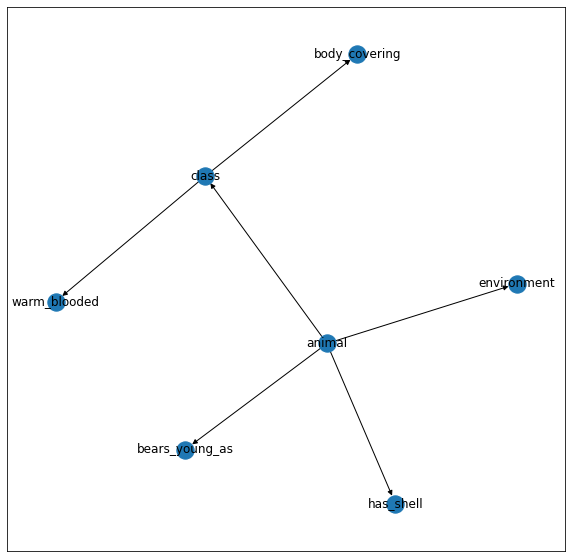

In [5]:
%matplotlib inline
vertices = {
    "animal": pd.DataFrame([[.2, .2, .2, .2, .2]], columns=animals),
    "environment": pd.DataFrame([
        [0., 1., 0.],
        [0., .5, .5],
        [0., 0., 1.],
        [.5, .5, 0.],
        [0., .5, .5]
    ], index=animals, columns=environments),
    "has_shell": pd.DataFrame([
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]
    ], index=animals, columns=has_shell),
    "bears_young_as": pd.DataFrame([
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]
    ], index=animals, columns=bears_types),
    "class": pd.DataFrame([
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], index=animals, columns=classes),
    "warm_blooded": pd.DataFrame([
        [1., 0.],
        [1., 0.],
        [0., 1.]
    ], index=classes, columns=warm_blooded),
    "body_covering": pd.DataFrame([
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], index=classes, columns=body_covering)
}

edges = [
    ["animal", "environment"],
    ["animal", "has_shell"],
    ["animal", "class"],
    ["animal", "bears_young_as"],
    ["class", "warm_blooded"],
    ["class", "body_covering"]
]

g = create_network(vertices, edges)
fig = plt.figure(figsize=(10, 10))
nx.draw_networkx(g, label="Animals Graph")
plt.show()

In [13]:
vertices["animal"]

,monkey,penguin,platypus,robin,turtle
0,0.2,0.2,0.2,0.2,0.2


In [8]:
jp = get_joint_probability(g)
jp[jp["joint_probability"]>0]

,variable_animal,variable_environment,variable_has_shell,variable_bears_young_as,variable_class,variable_warm_blooded,variable_body_covering,joint_probability
108,monkey,land,has_shell_false,live,mammal,warm_blooded_true,fur,0.2
259,penguin,land,has_shell_false,eggs,bird,warm_blooded_true,feathers,0.1
283,penguin,water,has_shell_false,eggs,bird,warm_blooded_true,feathers,0.1
570,platypus,water,has_shell_false,eggs,mammal,warm_blooded_true,fur,0.2
667,robin,air,has_shell_false,eggs,bird,warm_blooded_true,feathers,0.1
691,robin,land,has_shell_false,eggs,bird,warm_blooded_true,feathers,0.1
1043,turtle,land,has_shell_true,eggs,reptile,warm_blooded_false,scales,0.1
1067,turtle,water,has_shell_true,eggs,reptile,warm_blooded_false,scales,0.1


In [19]:
get_node_state_at(g, "body_covering")

,fur,feathers,scales
0,0.4,0.4,0.2


In [20]:
visit_asia = ["visit", "no_visit"]
smoking = ["smoking", "no_smoking"]
tuberculosis = ["tuberculosis_present", "tuberculosis_absent"]
lung_cancer = ["lung_cancer_present", "lung_cancer_absent"]
tub_or_cancer = ["tub_or_cancer_true", "tub_or_cancer_false"]
x_ray = ["abnormal", "normal"]
bronchitis = ["bronchitis_present",  "bronchitis_absent"]
dyspnea = ["dyspnea_present",  "dyspnea_absent"]

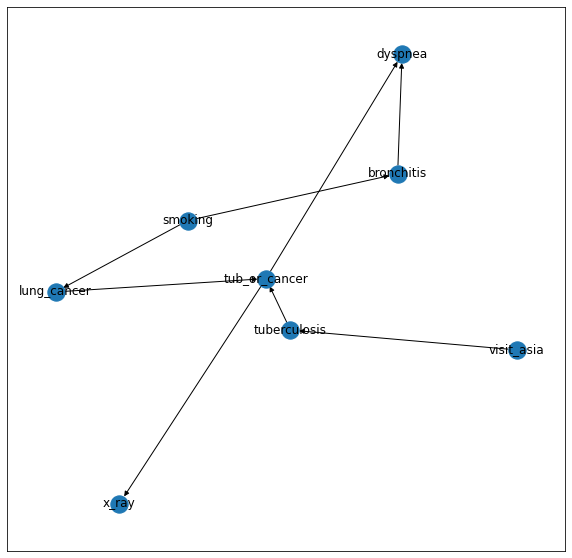

In [24]:
%matplotlib inline
vertices = {
    "visit_asia": pd.DataFrame([[.01, .99]], columns=visit_asia),
    "smoking": pd.DataFrame([[.5, .5]], columns=smoking),
    "tuberculosis": pd.DataFrame([
        [.05, .95],
        [.01, .99],
    ], index=visit_asia, columns=tuberculosis),
    "lung_cancer": pd.DataFrame([
        [.1, .9],
        [.01, .99],
    ], index=smoking, columns=lung_cancer),
    "tub_or_cancer": pd.DataFrame([
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]
    ], index=pd.MultiIndex.from_tuples(
        list(product(tuberculosis, lung_cancer)), names=["index_tub_or_cancer_tuberculosis", "index_tub_or_cancer_lung_cancer"]
    ), columns=tub_or_cancer),
    "x_ray": pd.DataFrame([
        [.98, .02],
        [.05, .95]
    ], index=tub_or_cancer, columns=x_ray),
    "bronchitis": pd.DataFrame([
        [.6, .4],
        [.3, .7]
    ], index=smoking, columns=bronchitis),
    "dyspnea": pd.DataFrame([
        [.9, .1],
        [.8, .2],
        [.7, .3],
        [.1, .9]
    ], index=pd.MultiIndex.from_tuples(
        list(product(bronchitis, tub_or_cancer)), names=["index_dyspnea_bronchitis", "index_dyspnea_tub_or_cancer"]
    ), columns=dyspnea)
}

edges = [
    ["visit_asia", "tuberculosis"],
    ["smoking", "lung_cancer"],
    ["smoking", "bronchitis"],
    ["bronchitis", "dyspnea"],
    ["tuberculosis", "tub_or_cancer"],
    ["lung_cancer", "tub_or_cancer"],
    ["tub_or_cancer", "x_ray"],
    ["tub_or_cancer", "dyspnea"]
]

g = create_network(vertices, edges)
fig = plt.figure(figsize=(10, 10))
nx.draw_networkx(g, label="Asia Graph")
plt.show()

In [31]:
vertices["dyspnea"]

dyspnea_present  \
index_dyspnea_bronchitis index_dyspnea_tub_or_cancer                    
bronchitis_present       tub_or_cancer_true                       0.9   
                         tub_or_cancer_false                      0.8   
bronchitis_absent        tub_or_cancer_true                       0.7   
                         tub_or_cancer_false                      0.1   

                                                      dyspnea_absent  
index_dyspnea_bronchitis index_dyspnea_tub_or_cancer                  
bronchitis_present       tub_or_cancer_true                      0.1  
                         tub_or_cancer_false                     0.2  
bronchitis_absent        tub_or_cancer_true                      0.3  
                         tub_or_cancer_false                     0.9

In [33]:
jp = get_joint_probability(g)
jp[jp["joint_probability"]>0].sort_values(by='joint_probability', ascending=False)

,variable_visit_asia,variable_tuberculosis,variable_tub_or_cancer,variable_x_ray,variable_dyspnea,variable_smoking,variable_lung_cancer,variable_bronchitis,joint_probability
255,no_visit,tuberculosis_absent,tub_or_cancer_false,normal,dyspnea_absent,no_smoking,lung_cancer_absent,bronchitis_absent,2.903620e-01
227,no_visit,tuberculosis_absent,tub_or_cancer_false,normal,dyspnea_present,smoking,lung_cancer_absent,bronchitis_present,2.011165e-01
251,no_visit,tuberculosis_absent,tub_or_cancer_false,normal,dyspnea_absent,smoking,lung_cancer_absent,bronchitis_absent,1.508374e-01
231,no_visit,tuberculosis_absent,tub_or_cancer_false,normal,dyspnea_present,no_smoking,lung_cancer_absent,bronchitis_present,1.106141e-01
243,no_visit,tuberculosis_absent,tub_or_cancer_false,normal,dyspnea_absent,smoking,lung_cancer_absent,bronchitis_present,5.027913e-02
...,...,...,...,...,...,...,...,...,...
150,visit,tuberculosis_absent,tub_or_cancer_true,normal,dyspnea_absent,no_smoking,lung_cancer_present,bronchitis_present,2.850000e-08
14,visit,tuberculosis_present,tub_or_cancer_true,normal,dyspnea_present,no_smoking,lung_cancer_present,bronchitis_absent,2.450000e-08
6,visit,tuberculosis_present,tub_or_cancer_true,normal,dyspnea_present,no_smoking,lung_cancer_present,bronchitis_present,1.350000e-08
30,visit,tuberculosis_present,tub_or_cancer_true,normal,dyspnea_absent,no_smoking,lung_cancer_present,bronchitis_absent,1.050000e-08


In [39]:
get_node_state_at(g, "dyspnea")

,dyspnea_present,dyspnea_absent
0,0.400793,0.599207
